In [1]:
import sys, os
import numpy as np
import scipy as sp
from typing import List, Tuple, Callable, Any, Dict

from methods.PolyCG.polycg.SO3 import so3
from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3
from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness

from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params

from methods.PolyCG.polycg.transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans

np.set_printoptions(linewidth=250,precision=5,suppress=True)

### Methods

In [2]:
### Generate unrestrained stiffness in composite basis

def transformed_coordinates_stiffmat(groundstate,stiffmat,midstep_locs):
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_locs
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
    
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    data = {}
    data['bare'] = stiffmat
    data['full'] = stiffmat_rearranged
    data['orig'] = MF
    data['comp'] = MC
    data['coup'] = MM
    
    data['comp_marginal'] = MC - MM @ np.linalg.inv(MF) @ MM.T
    data['orig_marginal'] = MF - MM.T @ np.linalg.inv(MC) @ MM
    data['F_jacob'] = np.log(np.linalg.det(transform))
    return data

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

### Calculate DNA groundstate between midstep triads
def midstep_groundstate(gs,midstep_locs):
    num = len(midstep_locs)-1
    mid_gs = np.zeros((num,6))
    for i in range(num):
        id1 = midstep_locs[i]
        id2 = midstep_locs[i+1]
        partial_gs = gs[id1:id2+1] 
        
        Smats = midstep_se3_groundstate(partial_gs)
        s_ij = np.eye(4)
        for Smat in Smats:
            s_ij = s_ij @ Smat
        mid_gs[i] = so3.se3_rotmat2euler(s_ij)
    return mid_gs

def valid_bonds(active_bonds):
    active_found = False
    tail_inactive_founds = False
    for bond in active_bonds:
        if bond:
            active_found = True
        if not bond and active_found:
            tail_inactive_founds = True
        if bond and tail_inactive_founds:
            return False
    return True

### Define Midstep Triad indices and static triads

In [3]:
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

midstep_constraint_locations = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]


active_bonds = np.ones(len(midstep_constraint_locations),dtype=bool)
# active_bonds[0] = False
# active_bonds[1] = False
# active_bonds[2] = False
# active_bonds[3] = False
# active_bonds[4] = False
# active_bonds[5] = False
# active_bonds[27] = False

print(f'bonds valid = {valid_bonds(active_bonds)}')

midstep_locs = np.array(midstep_constraint_locations)[active_bonds]
print(midstep_locs)

bonds valid = True
[  2   6  14  17  24  29  34  38  45  49  55  59  65  69  76  80  86  90  96 100 107 111 116 121 128 131 139 143]


### Generate Stiffness and Ground state

In [4]:
try:
    _gns = genstiff
except NameError:
    genstiff = GenStiffness(method='MD')

# seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
# randseq = 'TTCCACATGGATAATACAAGAGATTCATCGACGTGCTCATTTGGCATTAGGGCATCATCCTAATGAGATTCGGTGGCGCTAACAACTTCGCTGAAAGATCAGTGGAGCGAACTGCCCTACTGTTAATTGGGTACCAGACCTCCTCACATCGTTGGTAGCTCCGTTCCTCGCGGACCGCAAGGGCAAACGTCTTACGCGACATCTGTGAATCATAACTCAGTACTTTAAAGCTAGGGCGTATTATGCA'

seq = seq601
DNA_stiff,DNA_gs = genstiff.gen_params(seq,use_group=True)
DNA_data = transformed_coordinates_stiffmat(DNA_gs,DNA_stiff,midstep_locs)

midstep_gs  = midstep_groundstate(DNA_gs,midstep_locs)
Psi_0       = midstep_gs.flatten()

### Load MD Params

In [5]:
midstep_stiff_fn = 'MDParams/nuc_stiff.npy'
midstep_gs_fn    = 'MDParams/nuc_gs.npy'

nuc_midstep_stiff = np.load(midstep_stiff_fn)
nuc_midstep_gs    = np.load(midstep_gs_fn)

# # manuel fix for 4th and 22nd step
# print(nuc_midstep_gs[4*6:4*6+3])
# v4 = nuc_midstep_gs[4*6:4*6+3]
# nv4 = np.linalg.norm(v4) 
# uv4 = v4/nv4
# v4 = (-2*np.pi + nv4) * uv4
# nuc_midstep_gs[4*6:4*6+3] = v4
# print(v4)

# v22 = nuc_midstep_gs[22*6:22*6+3]
# nv22 = np.linalg.norm(v22) 
# uv22 = v22/nv22
# v22 = (-2*np.pi + nv22) * uv22
# nuc_midstep_gs[22*6:22*6+3] = v22

# first active
first = np.where(active_bonds)[0][0] 
last = np.where(active_bonds)[0][-1]

M_nuc   = nuc_midstep_stiff[first*6:last*6,first*6:last*6]
Chi_nuc = nuc_midstep_gs[first*6:last*6]


### Convert Nucleosome constraint to $\Psi$ coordinates

In [6]:
H = algebra2group_lintrans(Chi_nuc.reshape(len(Chi_nuc)//6,6),translation_as_midstep=False)
Hinv = group2algebra_lintrans(Chi_nuc.reshape(len(Chi_nuc)//6,6),translation_as_midstep=False)

print(M_nuc.shape)

Psi_C = H @ ( Chi_nuc - Psi_0 )
M_C_Psi = Hinv.T @ M_nuc @ Hinv

print(is_pos_def(M_C_Psi))


for i in range(len(midstep_gs)):

    print(i)
    print(Psi_C[i*6:(i+1)*6])
    # print(nuc_midstep_gs[i*6:(i+1)*6])
    # print(midstep_gs[i])

(162, 162)
True
0
[ 0.02553 -0.12171 -0.0956  -0.21717 -0.09436 -0.00603]
1
[ 0.07532 -0.31409  0.19398 -0.28169 -0.10725  0.04714]
2
[-0.25182 -0.19521  0.13684 -0.02242  0.13907  0.01867]
3
[ 0.36105  0.01357 -0.14454  0.11514 -0.45125  0.14434]
4
[-0.61921 -0.03518  0.20913  0.10712  0.44249  0.20608]
5
[ 0.30042 -0.04894 -0.02939  0.03067 -0.08741  0.05717]
6
[-0.34393 -0.22086  0.08638 -0.1129   0.19095  0.10819]
7
[ 0.22919  0.03177  0.08732  0.20904 -0.41764  0.11502]
8
[-0.56437 -0.04774  0.28929  0.24668  0.46178  0.19879]
9
[ 0.16663  0.0835  -0.03644 -0.03231 -0.00751 -0.05889]
10
[-0.56671 -0.06043  0.03216 -0.14279  0.29734  0.22593]
11
[ 0.13717  0.2415   0.12588  0.32707 -0.23864  0.10907]
12
[-0.56779 -0.34433  0.20194 -0.08777  0.46033  0.23067]
13
[ 0.16968 -0.05315  0.06323  0.01702 -0.1361   0.01017]
14
[-0.51855 -0.28631  0.28132  0.13452  0.43425  0.14734]
15
[ 0.14533 -0.07281  0.11272 -0.15454 -0.09566  0.01054]
16
[-0.53105 -0.21995  0.19158  0.03825  0.40803  

### Simpler Approch for imposed potential
Assume $M_I = M_C$ and then calculate $\Xi_I$ such that the correct groundstate is imposed

In [7]:
def imposed_potential(M_Xi,M_C_Psi,Psi_C):
    # extend potential to all dof
    M_I = np.zeros(M_Xi.shape)
    n = len(Psi_C)
    M_I[-n:,-n:] = M_C_Psi
    
    # calculate Psi_I
    Mtrans = np.linalg.inv(M_Xi+M_I) @ M_I.T
    Mtrans_Psi = Mtrans[-n:,-n:]
    Psi_I = np.linalg.inv(Mtrans_Psi) @ Psi_C

    # extend to Xi_I
    Xi_I = np.zeros(len(M_Xi))
    Xi_I[-n:] = Psi_I
    
    # calculate Xi_C
    Xi_C = Mtrans @ Xi_I
    
    # calculate M_eff
    M_eff = M_Xi+M_I
    
    # calculate constant terms
    E_const =  0.5 * Xi_I.T @ (M_I - M_I @ Mtrans) @ Xi_I
    return M_eff, E_const


### Calculate Free Energy

In [8]:
# Matrix
M_Phi    = DNA_data['orig']
M_Psi    = DNA_data['comp']
M_PhiPsi = DNA_data['coup']
M_Xi     = DNA_data['full']
M_eff, E_const = imposed_potential(M_Xi,M_C_Psi,Psi_C)

# entropy term
n = len(M_eff)
logdet_sign, logdet = np.linalg.slogdet(M_eff)
F_pi = -0.5*n * np.log(2*np.pi)
# matrix term
F_mat = 0.5*logdet
F_entro = F_pi + F_mat

F_jacob = DNA_data['F_jacob']


F_total = E_const + F_entro + F_jacob

print(f'E_const = {E_const}')
print(f'F_entro = {F_entro}')
print(f'F_jacob = {F_jacob}')
print(f'F_fluc = {F_entro+F_jacob}')
print(f'F_total = {F_total}')

E_const = 281.5704087897487
F_entro = 1929.4691039695072
F_jacob = -111.67528762564753
F_fluc = 1817.7938163438596
F_total = 2099.3642251336087


### Full Energy Calculation

In [9]:
def cal_energy(seq: str, active_bonds,midstep_constraint_locations,nuc_potential_factor: float = 1):
    
    if not valid_bonds:
        print('invalid bonds')
        return None
    
    midstep_locs = np.array(midstep_constraint_locations)[active_bonds]
    
    # generate stiffness data
    genstiff = GenStiffness(method='MD')
    DNA_stiff,DNA_gs = genstiff.gen_params(seq,use_group=True)
    DNA_data = transformed_coordinates_stiffmat(DNA_gs,DNA_stiff,midstep_locs)
    midstep_gs  = midstep_groundstate(DNA_gs,midstep_locs)
    Psi_0       = midstep_gs.flatten()
    
    # load MD Data
    midstep_stiff_fn = 'MDParams/nuc_stiff.npy'
    midstep_gs_fn    = 'MDParams/nuc_gs.npy'
    nuc_midstep_stiff = np.load(midstep_stiff_fn)*nuc_potential_factor
    nuc_midstep_gs    = np.load(midstep_gs_fn)
    
    
    ######## test
    from methods.free_energy import calculate_midstep_triads, midstep_excess_vals

    midstep_triads = calculate_midstep_triads(
        midstep_constraint_locations,
        nuctriads
    )
    # find contraint excess values
    excess_vals = midstep_excess_vals(
        DNA_gs,
        midstep_constraint_locations,
        midstep_triads
    )
    C = excess_vals.flatten()
    
    
    # # manuel fix for 4th and 22nd step
    # v4 = nuc_midstep_gs[4*6:4*6+3]
    # nv4 = np.linalg.norm(v4) 
    # uv4 = v4/nv4
    # v4 = (-2*np.pi + nv4) * uv4
    # nuc_midstep_gs[4*6:4*6+3] = v4

    # v22 = nuc_midstep_gs[22*6:22*6+3]
    # nv22 = np.linalg.norm(v22) 
    # uv22 = v22/nv22
    # v22 = (-2*np.pi + nv22) * uv22
    # nuc_midstep_gs[22*6:22*6+3] = v22
    
    
    # select constraint potential
    first = np.where(active_bonds)[0][0] 
    last = np.where(active_bonds)[0][-1]
    M_nuc   = nuc_midstep_stiff[first*6:last*6,first*6:last*6]
    Chi_nuc = nuc_midstep_gs[first*6:last*6]
            
    # transform potential to group definition
    H = algebra2group_lintrans(Chi_nuc.reshape(len(Chi_nuc)//6,6),translation_as_midstep=False)
    Hinv = group2algebra_lintrans(Chi_nuc.reshape(len(Chi_nuc)//6,6),translation_as_midstep=False)

    Psi_C = H @ ( Chi_nuc - Psi_0 )
    M_C_Psi = Hinv.T @ M_nuc @ Hinv
    
    C = C[first*6:last*6]
    # for i in range(len(Psi_C)//6):
    #     print('-----------')
    #     print(C[i*6:(i+1)*6])
    #     print(Psi_C[i*6:(i+1)*6])
    Psi_C = C
    
    
    # Matrix
    M_Phi    = DNA_data['orig']
    M_Psi    = DNA_data['comp']
    M_PhiPsi = DNA_data['coup']
    M_Xi     = DNA_data['full']
    M_eff, E_const = imposed_potential(M_Xi,M_C_Psi,Psi_C)

    # entropy term
    n = len(M_eff)
    logdet_sign, logdet = np.linalg.slogdet(M_eff)
    F_pi = -0.5*n*6 * np.log(2*np.pi)
    # matrix term
    F_mat = 0.5*logdet
    F_entro = F_pi + F_mat

    F_jacob = DNA_data['F_jacob']
    F_total = E_const + F_entro + F_jacob
    
    # bare DNA 
    logdet_sign, logdet = np.linalg.slogdet(DNA_stiff)
    F_bare = 0.5*logdet + F_pi
    
    # full DNA 
    logdet_sign, logdet = np.linalg.slogdet(M_Xi)
    F_full = 0.5*logdet + F_pi + F_jacob
    
    results = {
        'total': F_total,
        'const': E_const,
        'fluc' : F_entro+F_jacob,
        'entro': F_entro,
        'jacob': F_jacob,
        'mat'  : F_mat,
        'pi'   : F_pi,
        'full' : F_full,
        'bare' : F_bare
    }
    return results


In [10]:
midstep_constraint_locations = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]

active_bonds = np.ones(len(midstep_constraint_locations),dtype=bool)
# active_bonds[0] = False
# active_bonds[1] = False
# active_bonds[2] = False
# active_bonds[3] = False
# active_bonds[4] = False
# active_bonds[5] = False
# active_bonds[27] = False

# seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
# randseq = 'TTCCACATGGATAATACAAGAGATTCATCGACGTGCTCATTTGGCATTAGGGCATCATCCTAATGAGATTCGGTGGCGCTAACAACTTCGCTGAAAGATCAGTGGAGCGAACTGCCCTACTGTTAATTGGGTACCAGACCTCCTCACATCGTTGGTAGCTCCGTTCCTCGCGGACCGCAAGGGCAAACGTCTTACGCGACATCTGTGAATCATAACTCAGTACTTTAAAGCTAGGGCGTATTATGCA'
seq = seq601

results = cal_energy(seq, active_bonds,midstep_constraint_locations)

print(f"E_const = {results['const']}")
print(f"F_entro = {results['entro']}")
print(f"F_mat   = {results['mat']}")
print(f"F_pi    = {results['pi']}")
print(f"F_jacob = {results['jacob']}")
print(f"F_fluc = {results['fluc']}")
print(f"F_total = {results['total']}")

E_const = 96.73407501653504
F_entro = -2095.481671466959
F_mat   = 2734.4592590568004
F_pi    = -4829.94093052376
F_jacob = -111.67528762564753
F_fluc = -2207.1569590926065
F_total = -2110.4228840760716


In [13]:
energies = []

active_bonds = np.ones(len(midstep_constraint_locations),dtype=bool)
for i in range(len(active_bonds)-1):
    seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
    seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
    randseq = 'TTCCACATGGATAATACAAGAGATTCATCGACGTGCTCATTTGGCATTAGGGCATCATCCTAATGAGATTCGGTGGCGCTAACAACTTCGCTGAAAGATCAGTGGAGCGAACTGCCCTACTGTTAATTGGGTACCAGACCTCCTCACATCGTTGGTAGCTCCGTTCCTCGCGGACCGCAAGGGCAAACGTCTTACGCGACATCTGTGAATCATAACTCAGTACTTTAAAGCTAGGGCGTATTATGCA'
    seq = seq601
    # seq = randseq

    # results = cal_energy(seq, active_bonds,midstep_constraint_locations, nuc_potential_factor=0.42)
    results = cal_energy(seq, active_bonds,midstep_constraint_locations, nuc_potential_factor=0.5)

    # print(f"E_const = {results['const']}")
    # print(f"F_entro = {results['entro']}")
    # print(f"F_jacob = {results['jacob']}")
    # print(f"F_fluc = {results['fluc']}")
    print(i)
    print(f"F_total = {results['total']-results['bare']}")
    print(f"F_bare = {results['bare']}")
    print(f"F_full = {results['full']}")
    
    energies.append([results[key] for key in results])
    active_bonds[-1-i] = False
    # active_bonds[i] = False

energies = np.array(energies)  
print(energies)


0
F_total = 319.9542338209767
F_bare = -2375.897755614104
F_full = -2375.897755613989
1
F_total = 312.028361265101
F_bare = -2375.897755614104
F_full = -2375.897755614171
2
F_total = 300.8577624176446
F_bare = -2375.897755614104
F_full = -2375.897755614136
3
F_total = 291.30239036968624
F_bare = -2375.897755614104
F_full = -2375.897755613971
4
F_total = 278.30581290482405
F_bare = -2375.897755614104
F_full = -2375.8977556141485
5
F_total = 261.99806266444966
F_bare = -2375.897755614104
F_full = -2375.897755613946
6
F_total = 251.73274985232
F_bare = -2375.897755614104
F_full = -2375.8977556140953
7
F_total = 237.95519293820325
F_bare = -2375.897755614104
F_full = -2375.897755614117
8
F_total = 224.66153297139044
F_bare = -2375.897755614104
F_full = -2375.8977556140276
9
F_total = 210.6596797154075
F_bare = -2375.897755614104
F_full = -2375.8977556140717
10
F_total = 198.57202926472337
F_bare = -2375.897755614104
F_full = -2375.8977556140603
11
F_total = 187.0891571574748
F_bare = -2375

# plot

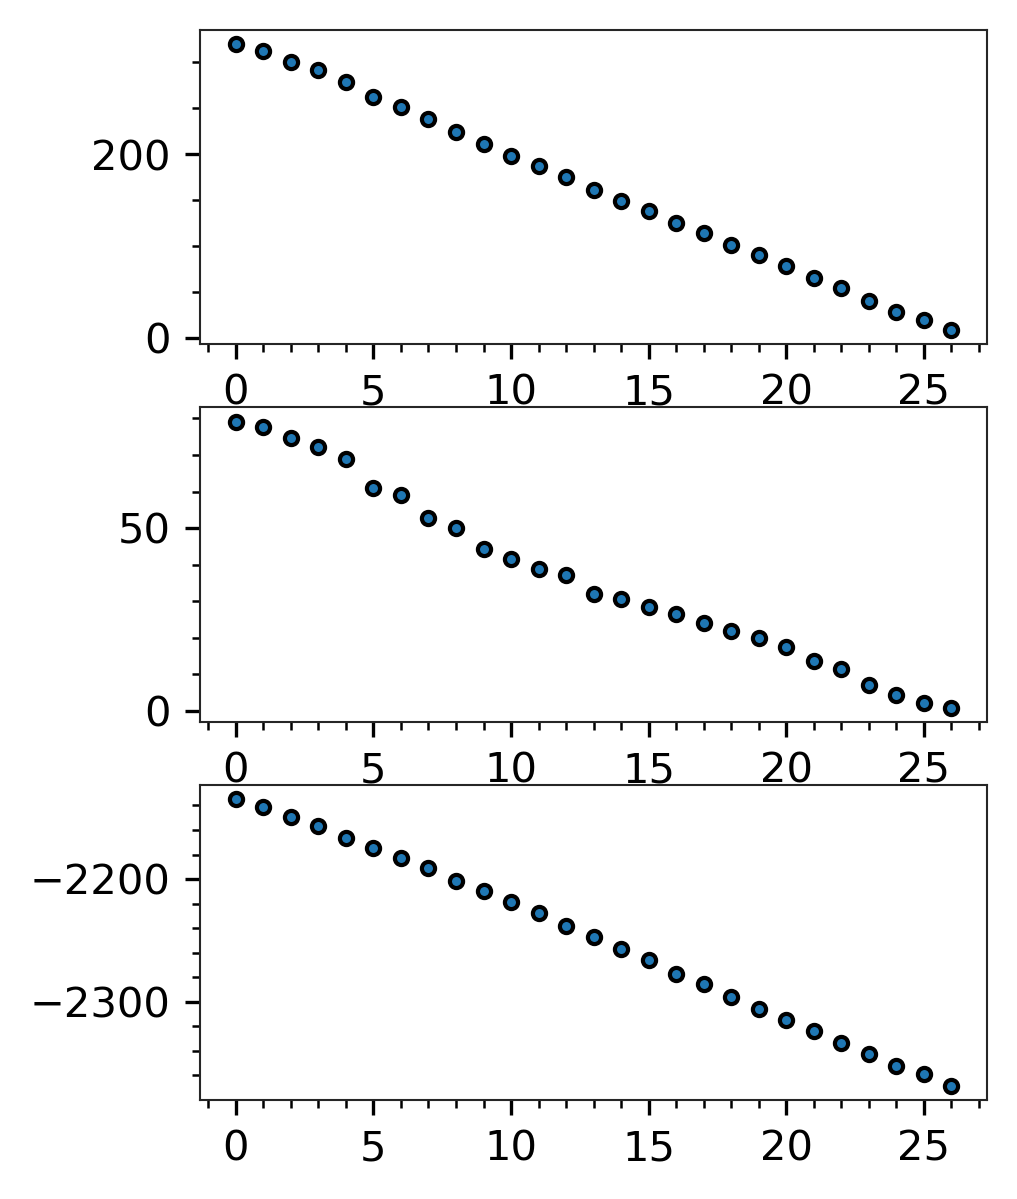

In [14]:
###########################################################################################
### FIGURE SETUP
###########################################################################################
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8.6/2.54, 12/2.54), dpi=300,facecolor='w',edgecolor='k') 

ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), colspan=1,rowspan=1)
plt.minorticks_on() 
ax2 = plt.subplot2grid(shape=(3, 1), loc=(1, 0), colspan=1,rowspan=1)
plt.minorticks_on() 
ax3 = plt.subplot2grid(shape=(3, 1), loc=(2, 0), colspan=1,rowspan=1)
plt.minorticks_on() 

bonds = np.arange(len(energies))
ax1.scatter(bonds,energies[:,0]-energies[:,-1],s=10,marker='o',edgecolor='black')
ax2.scatter(bonds,energies[:,1],s=10,marker='o',edgecolor='black')
ax3.scatter(bonds,energies[:,2],s=10,marker='o',edgecolor='black')

plt.show()